# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Hier Pfad ändern um eigene Daten zu nutzen:

In [2]:
train_path = '../Desktop/gyval1.csv'#this should be your reference data
test_path = '../Desktop/gyval3.csv' #replace this with your new data

Dataframes erstellen:

In [3]:
df1 = pd.read_csv(train_path,sep=';')
df2 = pd.read_csv(test_path,sep=';')
df1['timing'] = range(1, len(df1) + 1)
df2['timing'] = range(1, len(df2) + 1)
df1.set_index('timing')
df2.set_index('timing')

,xVal,yVal,zVal
timing,,,
1,-0.0,0.0,-0.0
2,-0.0,0.0,-0.0
3,-0.0,0.0,0.0
4,-0.0,0.0,0.0
5,0.0,0.0,0.0
...,...,...,...
3992,0.0,0.0,-0.0
3993,0.0,-0.0,0.0
3994,0.0,0.0,0.0


In [4]:
df1.head()

,xVal,yVal,zVal,timing
0,-0.0,0.0,-0.0,1
1,-0.0,0.0,-0.0,2
2,-0.0,0.0,0.0,3
3,-0.0,0.0,0.0,4
4,0.0,0.0,0.0,5


In [5]:
df2.head()

,xVal,yVal,zVal,timing
0,-0.0,0.0,-0.0,1
1,-0.0,0.0,-0.0,2
2,-0.0,0.0,0.0,3
3,-0.0,0.0,0.0,4
4,0.0,0.0,0.0,5


# Referenzdatensatz
Dieser Plot zeigt die Daten, mit welchen das Modell trainiert werden soll.
In unserem Fall ein normaler MPU9250 Messdurchlauf im Testfeld des EmRoLab.

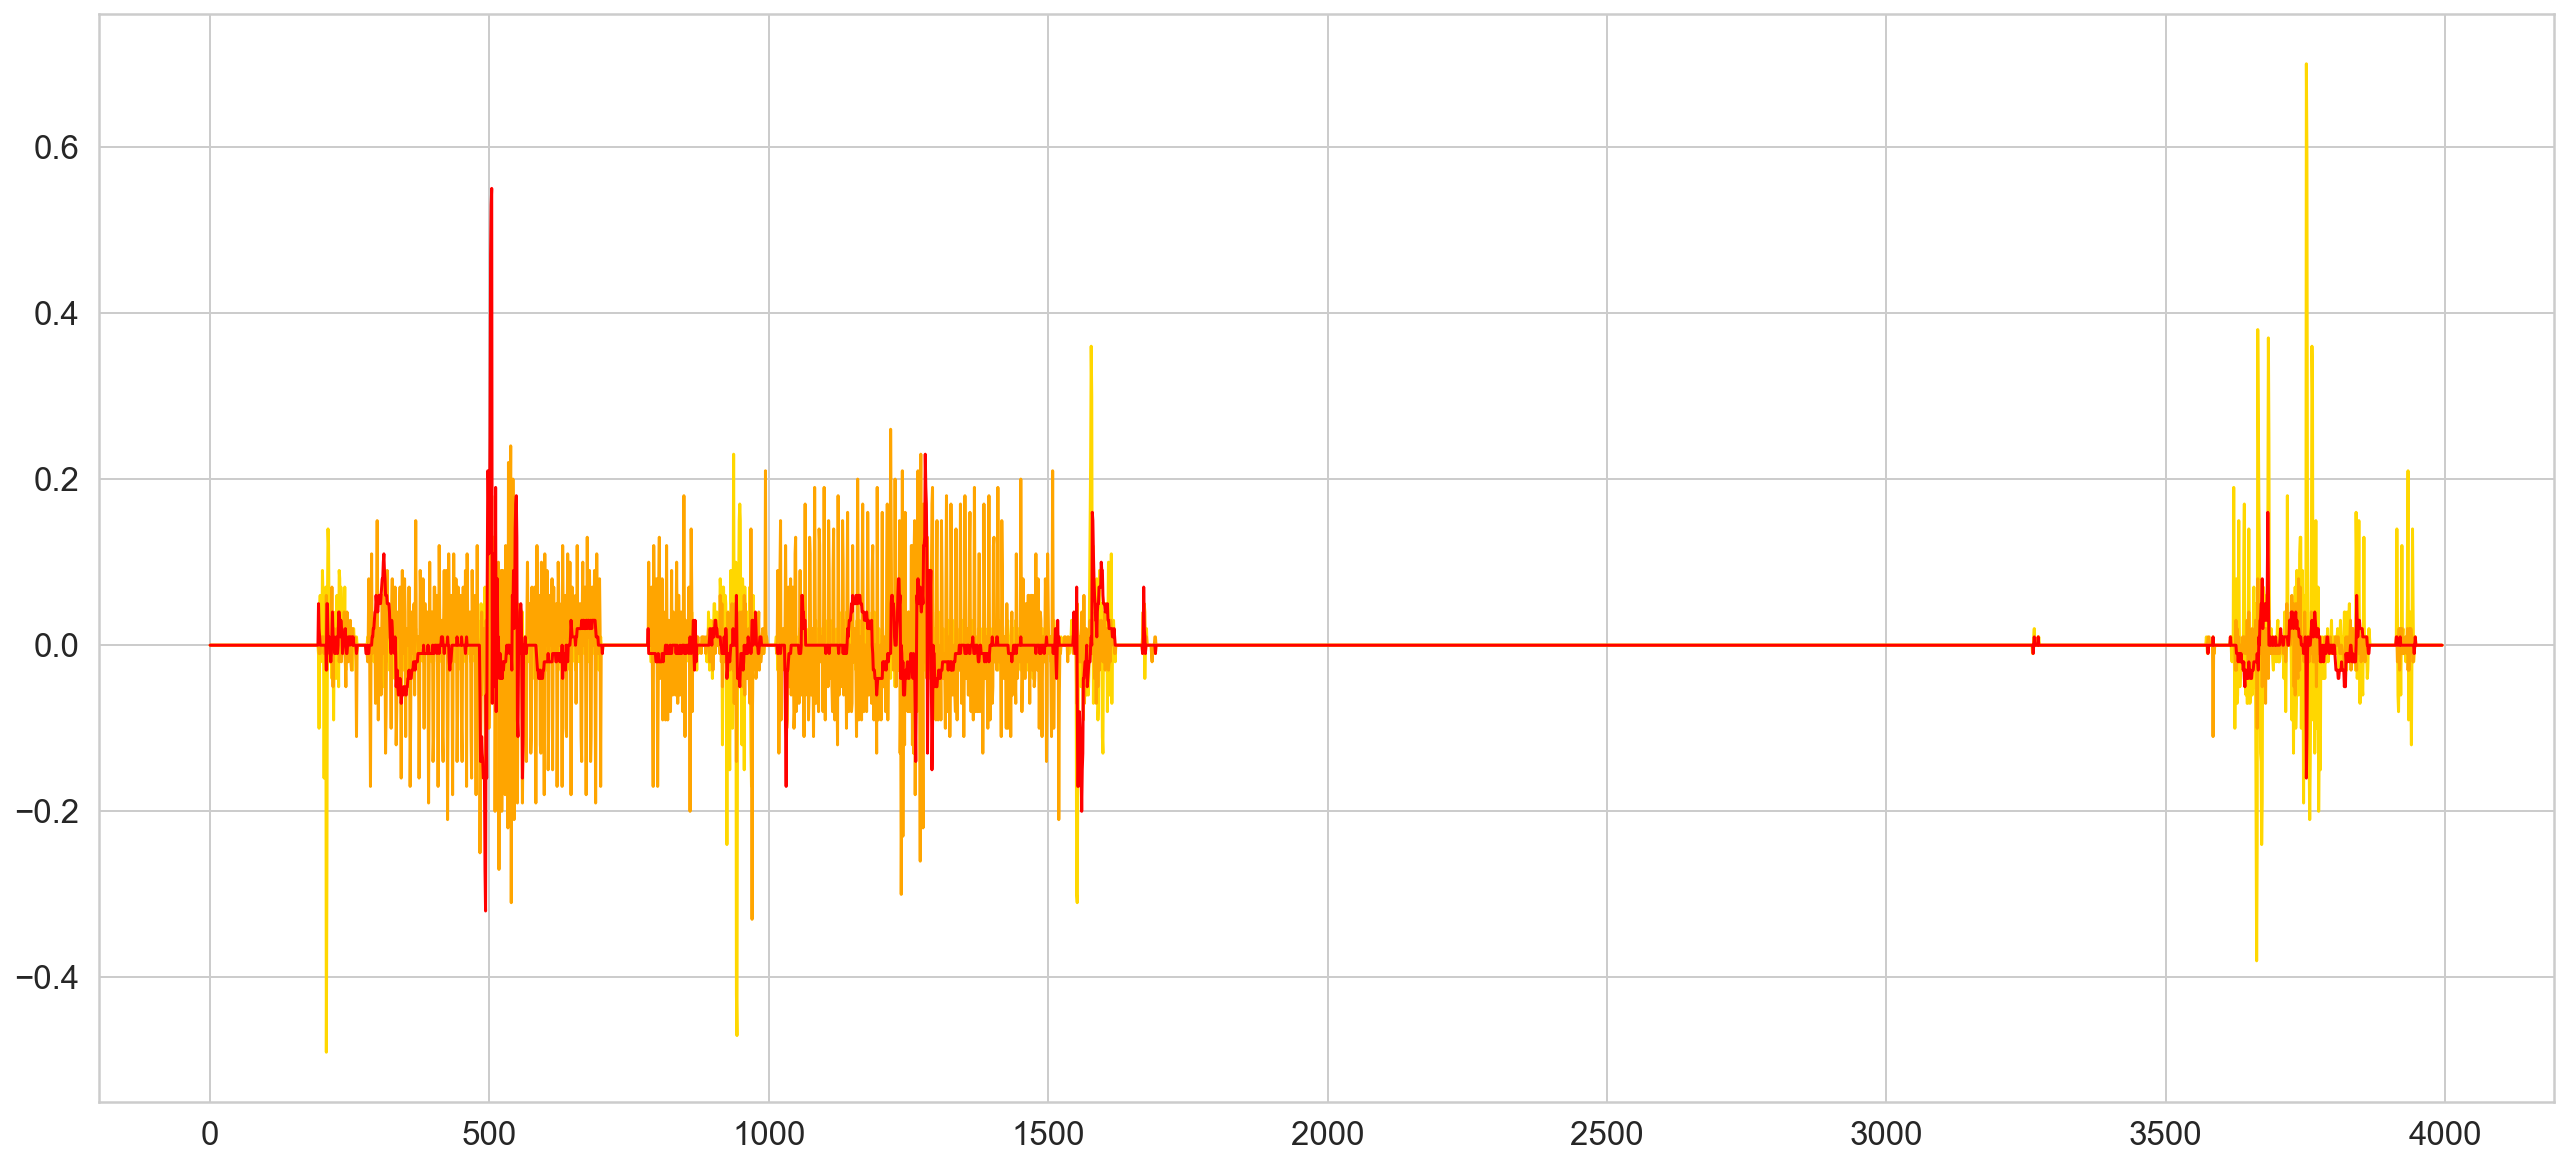

In [6]:
plt.plot(df1['xVal'], label='dataX', color='gold')
plt.plot(df1['yVal'], label='dataY', color='orange')
plt.plot(df1['zVal'], label='dataZ', color='red')

# Abweichender Datensatz
In der x-Range zwischen 2500 bis 3000 treten 2 Abweichungen auf. Bei der ersten handelt es sich um
ein sogenanntes Gap, bei der zweiten um eine reproduktion der Anfangsbewegung in der x-Range nach 3600.
Demnach sollte die unnatürliche Bewegung erkannt werden und die natürliche nicht, da sich einfach der Träger
in diesem Messlauf anders verhalten haben könnte.

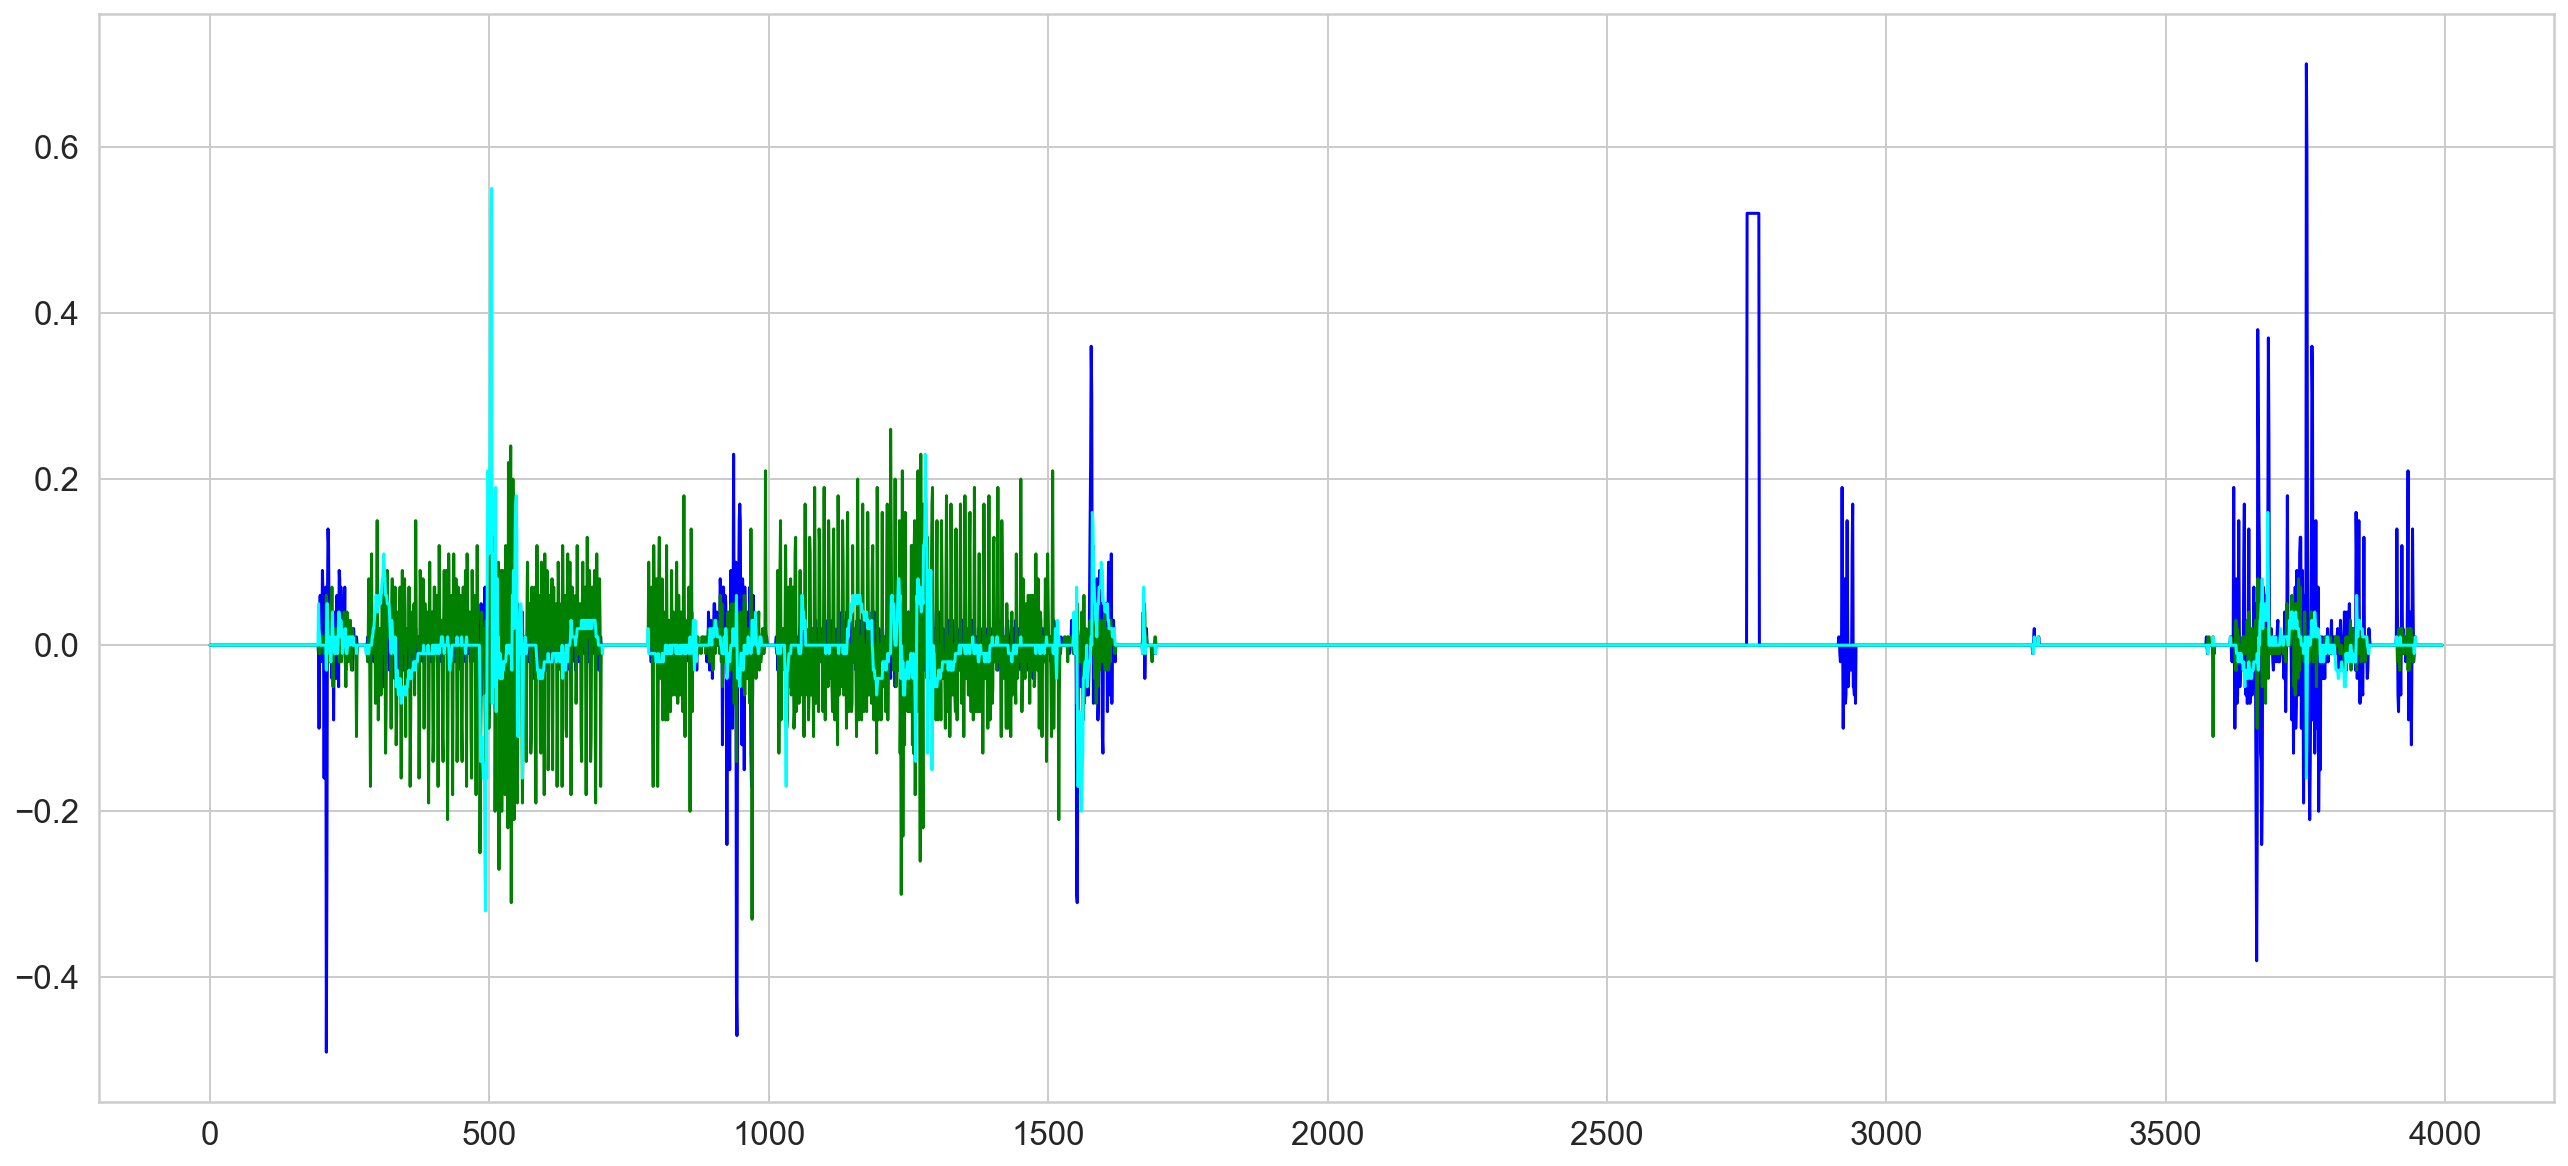

In [7]:
plt.plot(df2['xVal'], label='dataX', color='blue')
plt.plot(df2['yVal'], label='dataY', color='green')
plt.plot(df2['zVal'], label='dataZ', color='cyan')

Für das Training und Testen werden zwei vollständige Datensätze der gleichen Länge verwendet.

In [8]:
train_size = int(len(df1) * 1)
test_size = int(len(df2) * 1)
train= df1.iloc[0:train_size]
test = df2.iloc[0:len(df2)]
print(train.shape, test.shape)

(3996, 4) (3996, 4)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['xVal']])

train['xVal'] = scaler.transform(train[['xVal']])
test['dataX'] = scaler.transform(test[['xVal']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [10]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [11]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['xVal']], train.xVal, TIME_STEPS)
X_test, y_test = create_dataset(test[['xVal']], test.xVal, TIME_STEPS)

print(X_train.shape)

(3966, 30, 1)


In [12]:

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=77,
    validation_split=0.1,
    shuffle=False
)

Train on 3569 samples, validate on 397 samples
Epoch 1/300
3569/3569 [==============================] - 14s 4ms/sample - loss: 0.2157 - val_loss: 1.1262
Epoch 2/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.2133 - val_loss: 1.1191
Epoch 3/300
3569/3569 [==============================] - 9s 2ms/sample - loss: 0.2123 - val_loss: 1.1191
Epoch 4/300
3569/3569 [==============================] - 9s 2ms/sample - loss: 0.2119 - val_loss: 1.1186
Epoch 5/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.2109 - val_loss: 1.1196
Epoch 6/300
3569/3569 [==============================] - 9s 2ms/sample - loss: 0.2113 - val_loss: 1.1148
Epoch 7/300
3569/3569 [==============================] - 9s 2ms/sample - loss: 0.2111 - val_loss: 1.1037
Epoch 8/300
3569/3569 [==============================] - 10s 3ms/sample - loss: 0.2085 - val_loss: 1.1045
Epoch 9/300
3569/3569 [==============================] - 9s 2ms/sample - loss: 0.2085 - val_loss: 1.0997
Epoch 

Epoch 78/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.1692 - val_loss: 1.2360
Epoch 79/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.1672 - val_loss: 1.3450
Epoch 80/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.1674 - val_loss: 1.1797
Epoch 81/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.1715 - val_loss: 1.2949
Epoch 82/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1711 - val_loss: 1.2227
Epoch 83/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1685 - val_loss: 1.2313
Epoch 84/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.1655 - val_loss: 1.2343
Epoch 85/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1652 - val_loss: 1.2486
Epoch 86/300
3569/3569 [==============================] - 7s 2ms/sample - loss: 0.1622 - val_loss: 1.2487
Epoch 87/300
3569/3569 [======================

3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1406 - val_loss: 1.2798
Epoch 155/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1411 - val_loss: 1.2252
Epoch 156/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1411 - val_loss: 1.2105
Epoch 157/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1411 - val_loss: 1.2429
Epoch 158/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1405 - val_loss: 1.2650
Epoch 159/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1419 - val_loss: 1.2333
Epoch 160/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1430 - val_loss: 1.2151
Epoch 161/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1417 - val_loss: 1.2229
Epoch 162/300
3569/3569 [==============================] - 8s 2ms/sample - loss: 0.1443 - val_loss: 1.2196
Epoch 163/300
3569/3569 [==========================

3569/3569 [==============================] - 10s 3ms/sample - loss: 0.1226 - val_loss: 1.2926
Epoch 231/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1235 - val_loss: 1.2547
Epoch 232/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1216 - val_loss: 1.2836
Epoch 233/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1223 - val_loss: 1.2459
Epoch 234/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1264 - val_loss: 1.3465
Epoch 235/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1307 - val_loss: 1.2914
Epoch 236/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1275 - val_loss: 1.3503
Epoch 237/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1240 - val_loss: 1.2829
Epoch 238/300
3569/3569 [==============================] - 11s 3ms/sample - loss: 0.1223 - val_loss: 1.2772
Epoch 239/300
3569/3569 [=================

In [21]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

Diese Verteilungskurve nutzen um einen THRESHOLD-Parameter zu definieren.

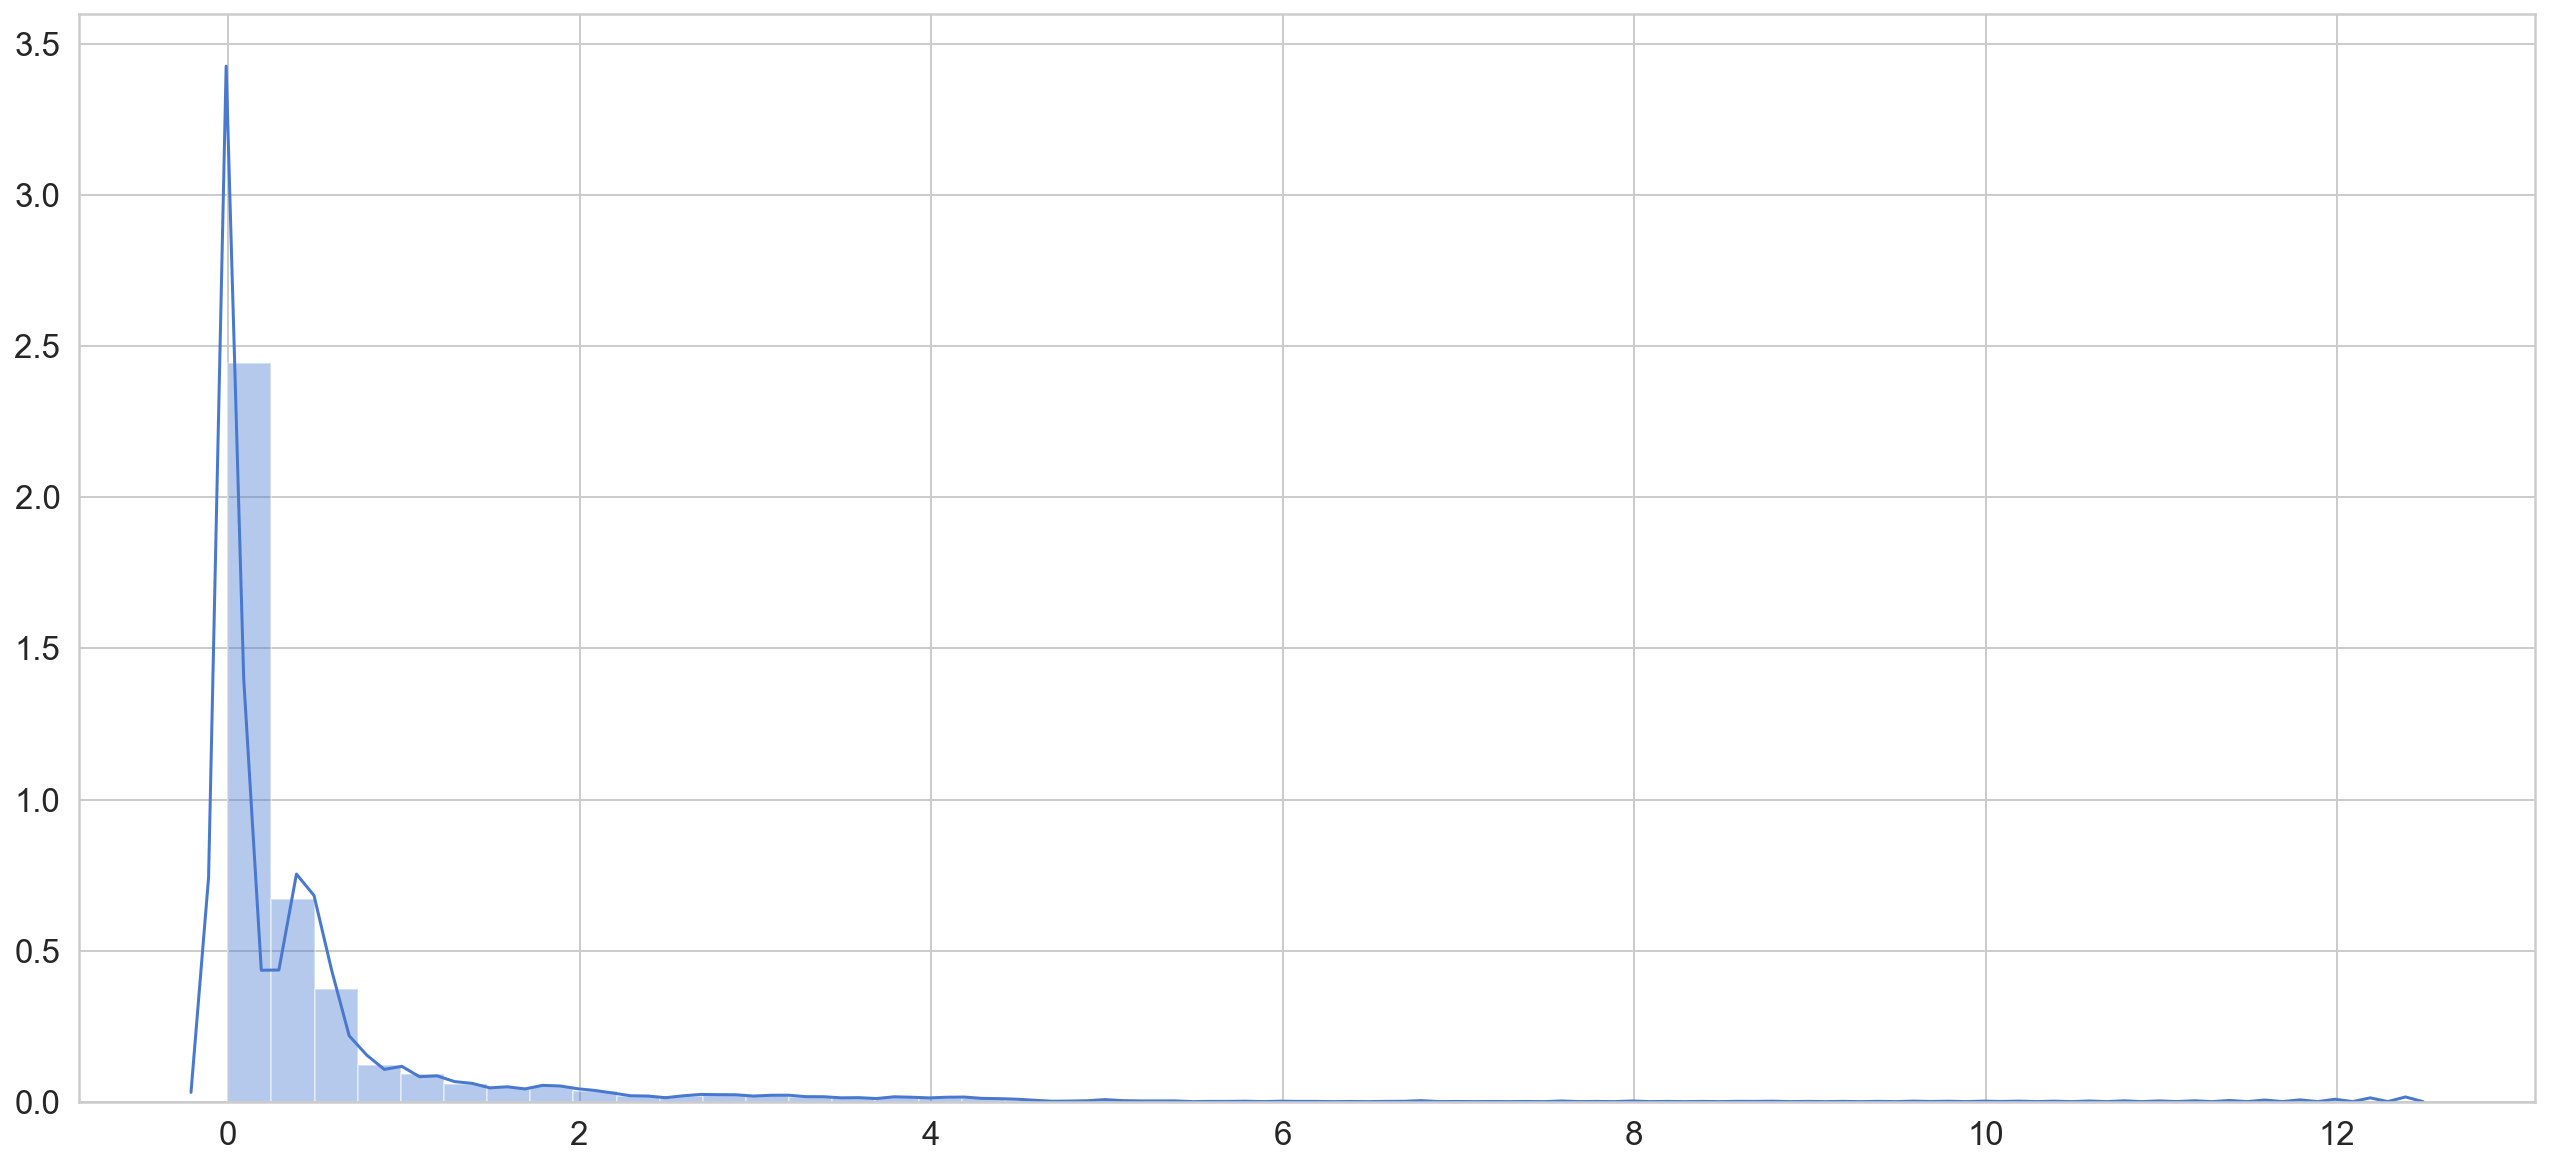

In [22]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [23]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [24]:
THRESHOLD = 0.8

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['dataX'] = test[TIME_STEPS:].dataX

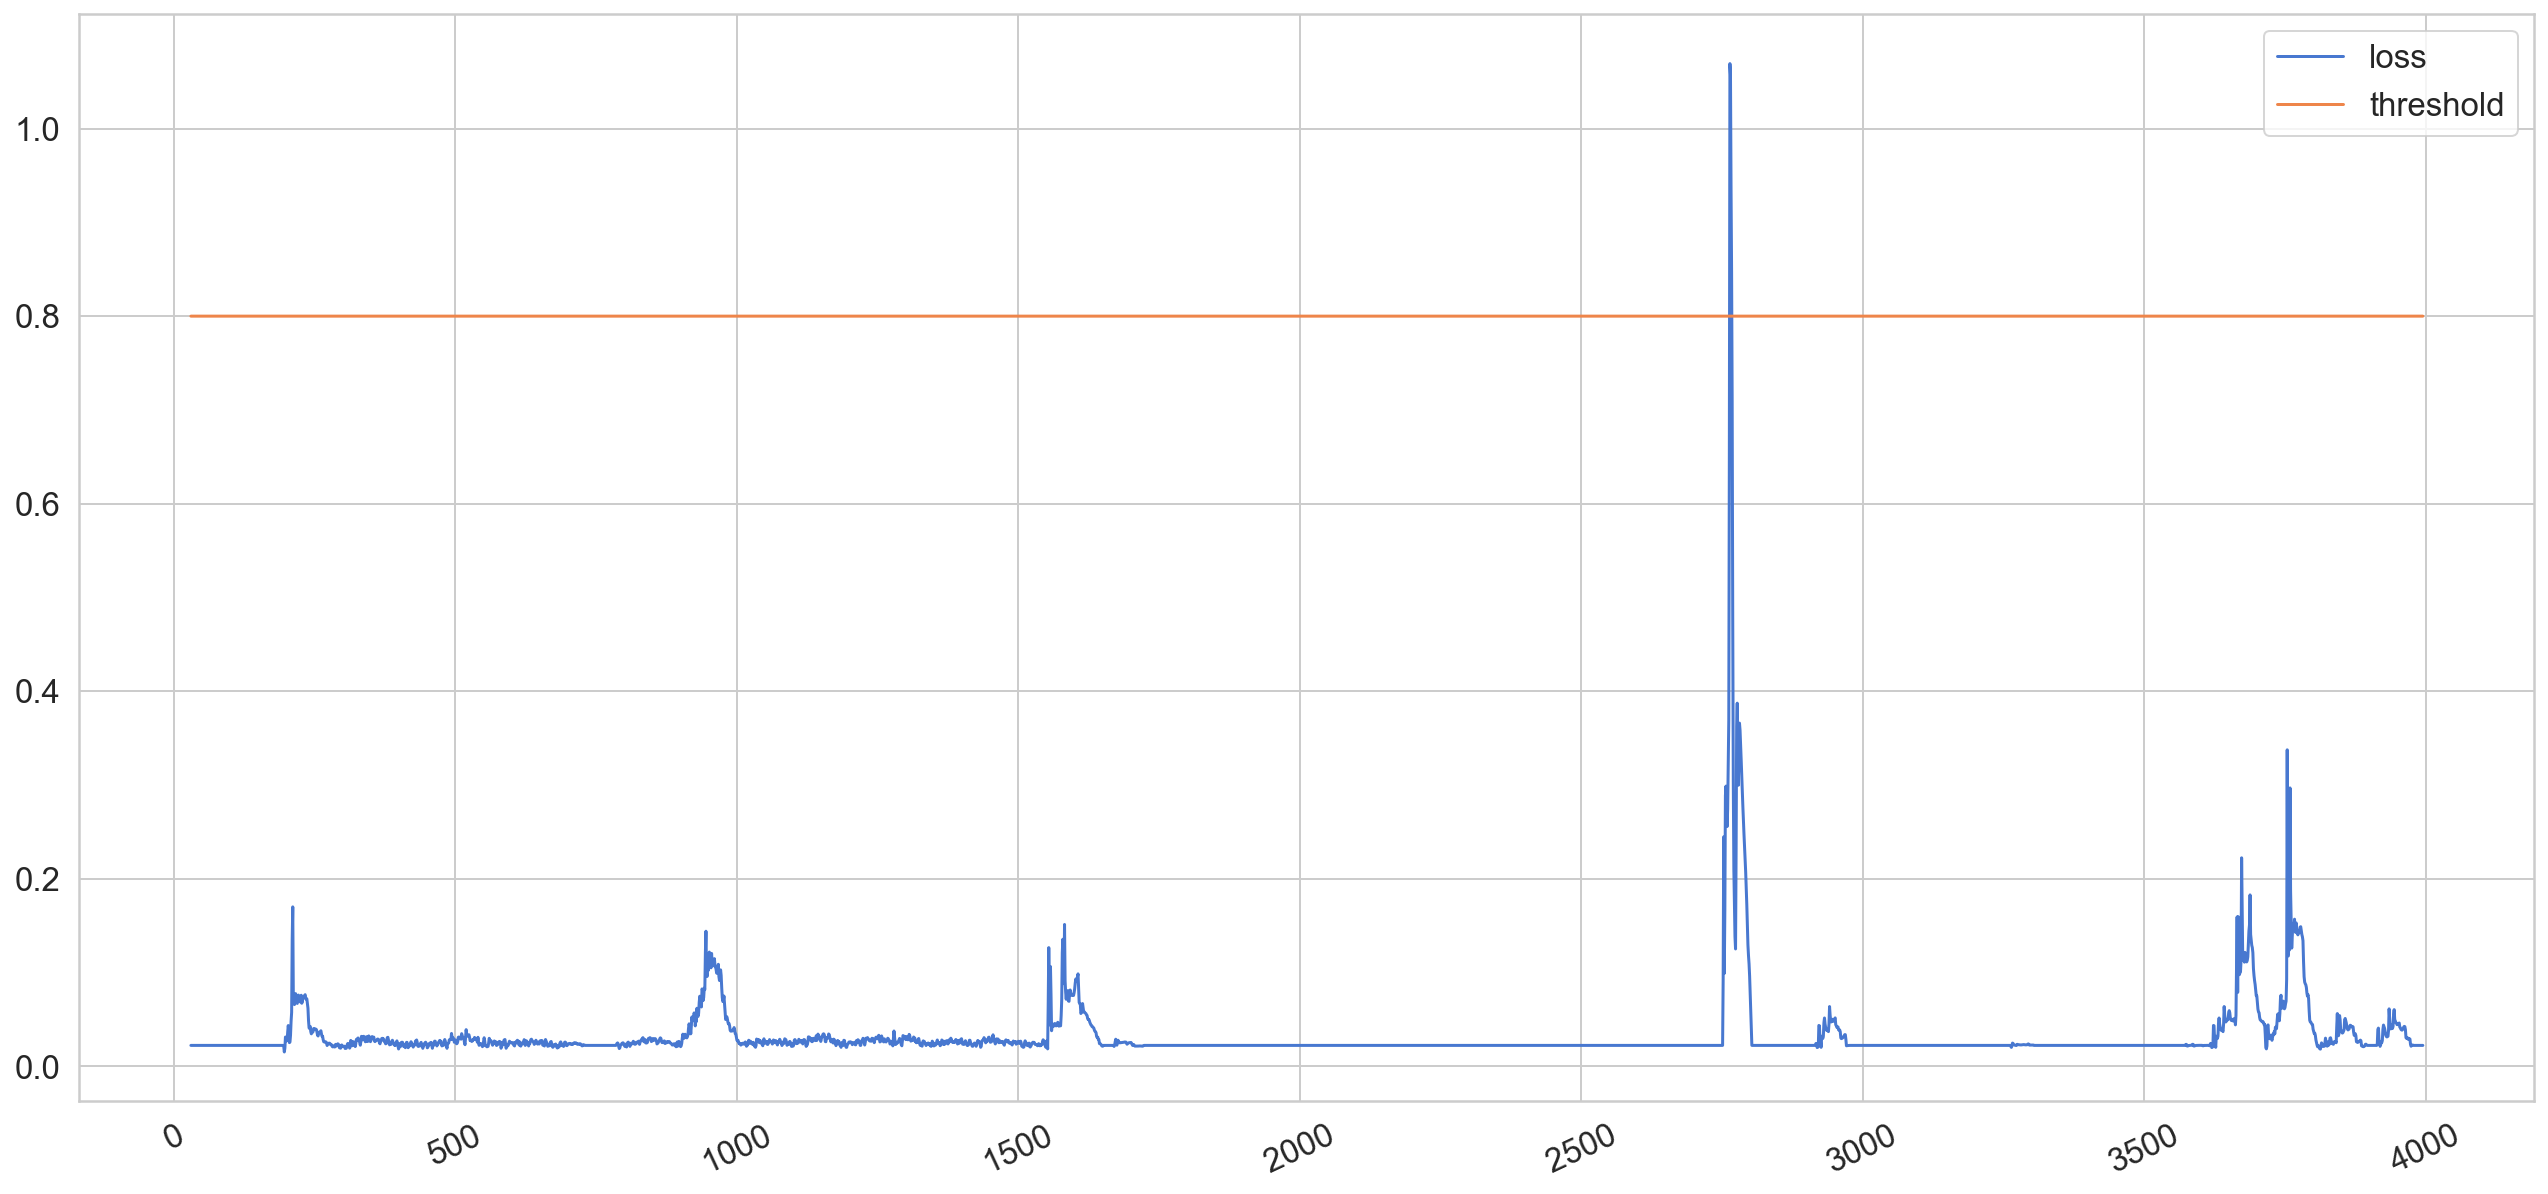

In [25]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [26]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,dataX
2764,1.069294,0.8,True,14.283098
2765,1.057384,0.8,True,14.283098
2766,0.937404,0.8,True,14.283098
2767,0.846443,0.8,True,14.283098


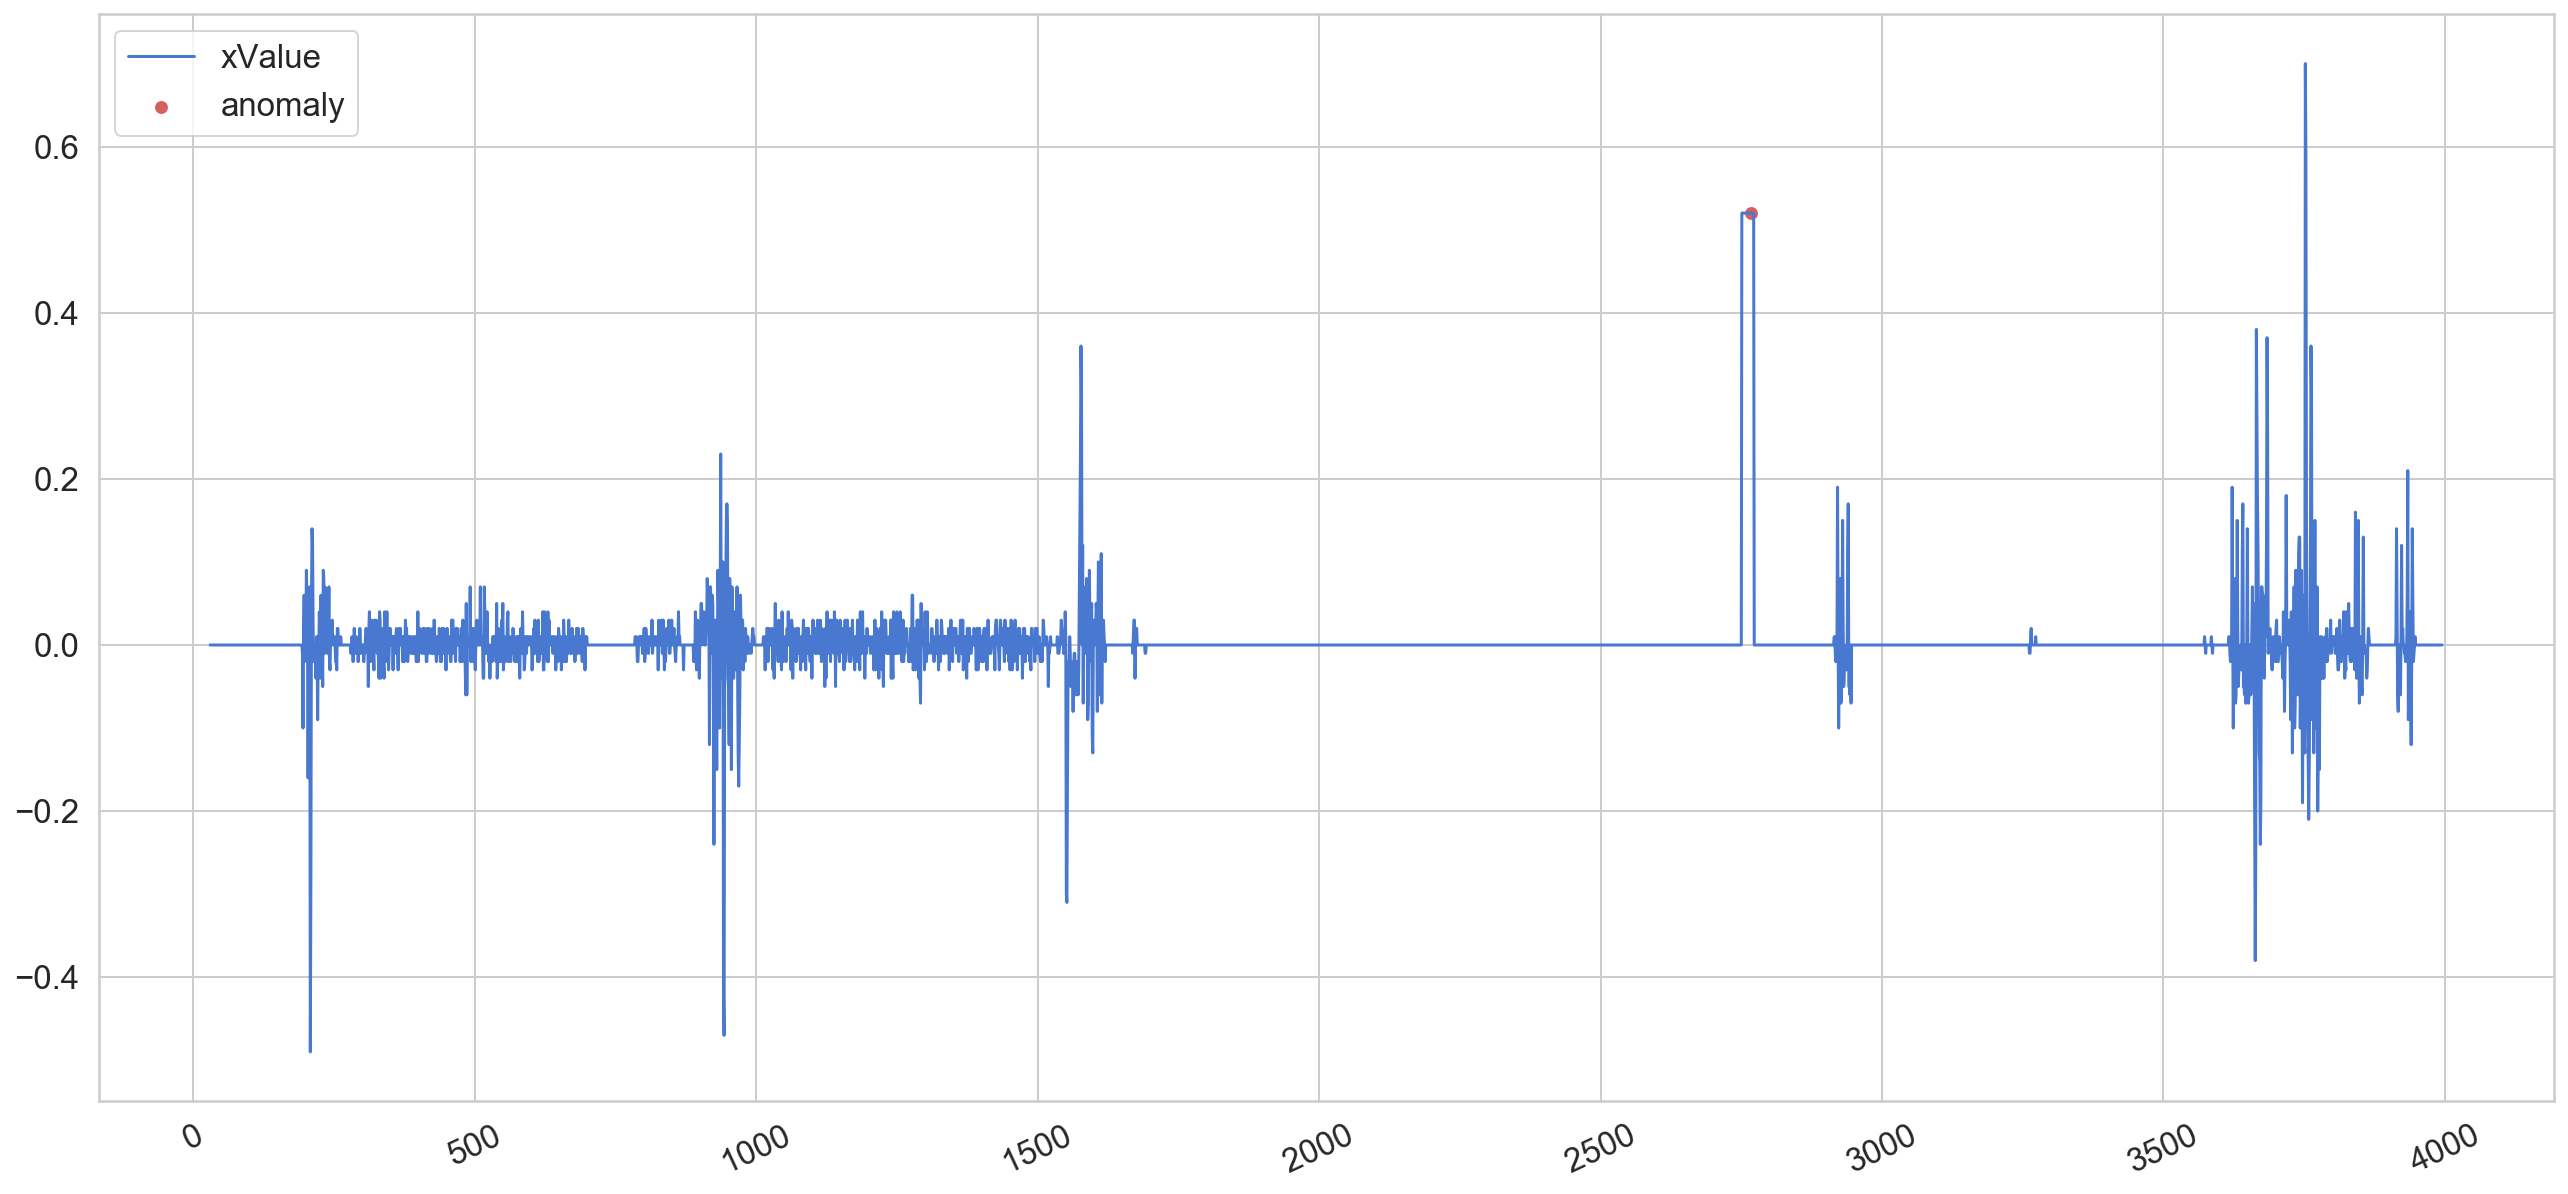

In [27]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].dataX), 
  label='xValue'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.dataX),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();